<a href="https://colab.research.google.com/github/SebastianBenini/Financial_Fraud_Detection/blob/main/Proyecto_Deteccion_Fraude_Financiero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. *CONFIGURACION DEL AMBIENTE*

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,roc_auc_score, roc_curve, f1_score
global df_banco, resultados

###2. *PREPROCESAMIENTO DE DATOS*

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_banco = pd.read_csv("/content/drive/MyDrive/datasets/transacciones_dataset.csv", sep=",")
df_banco.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df_banco.shape

(6362620, 11)

In [6]:
df_banco.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Analisis de los datos:
1.   Todos los "isFlaggedFraud = 1" cumplen estas condiciones (16)
  *   mount > 200000.00
  *   type = TRANSFER
  *   isFraud = 1
2.   Los Fraudes solo se producen en:
  *   type = TRANSFER y CASH_OUT
  *   type2_CC = 1
3.   Siempre se cumple que
  *   oldbalanceOrg - amount = newbalanceOrig
  
Las cuentas para las transferencias siempre son distintas

In [7]:
def procesar_datos():
    global df_banco
    #Creacion de la variable type2
    df_banco["type2"] = df_banco["nameDest"].apply(lambda x : "CC" if x[0] == "C" else "CM")
    #Convierto los valores categoricos a continuos con el metodo get_dummies
    df_banco = pd.get_dummies(df_banco, columns=['type','type2'], dtype=int)
    #Elimino Columnas prescindibles
    df_banco.drop(['nameOrig', 'nameDest', 'isFlaggedFraud','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], axis=1, inplace=True)
    #Eliminando duplicados
    df_banco.drop_duplicates(inplace=True)
    # Tratamiento de nulos
    df_banco.dropna(inplace=True)

In [8]:
procesar_datos()
df_banco.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1


###3. *EXPLORAMIENTO DE DATOS*

In [9]:
#Observemos la variable target isFraud
df_banco["isFraud"].value_counts()

isFraud
0    6346920
1       8103
Name: count, dtype: int64

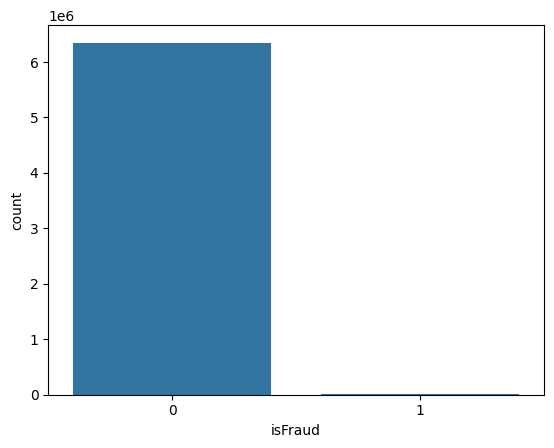

In [10]:
ax = sns.countplot(x="isFraud", data=df_banco)

La variable isFraud esta muy desbalanceada, tendremos que arreglar esto

<Axes: >

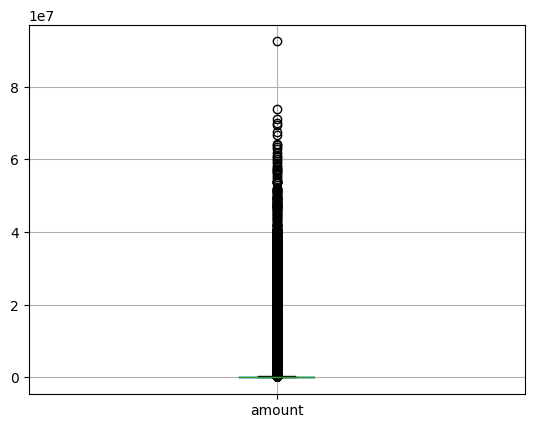

In [11]:
df_banco.boxplot(["amount"])

Los montos tienen mucho outlier lo cual esto puede afectar al modelo, mejor deshacernos de ellos

In [12]:
def boxploting():
    global df_banco
    amount = df_banco["amount"]
    q1 = amount.quantile(.25)
    q3 = amount.quantile(.75)
    iiq = q3 - q1
    limite_inferior = q1 - 1.5 * iiq
    limite_superior = q3 + 1.5 * iiq
    select = ((amount >= limite_inferior) & (amount <= limite_superior))
    df_banco = df_banco[select]
    #Eliminando duplicados
    df_banco.drop_duplicates(inplace=True)
    #Tratamiento de nulos
    df_banco.dropna(inplace=True)

<Axes: >

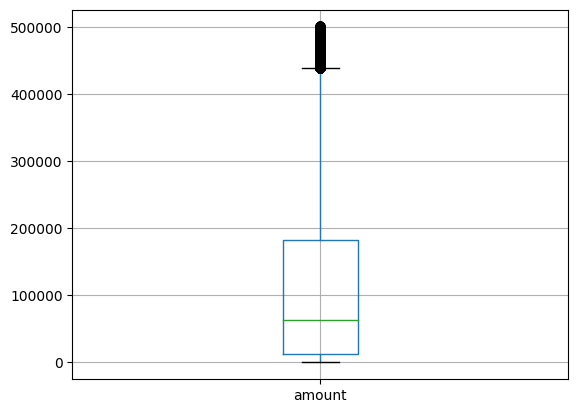

In [13]:
boxploting()
df_banco.boxplot(["amount"])

In [14]:
def balanceo_clases():
    global df_banco
    x = df_banco.drop("isFraud", axis=1)
    y = df_banco["isFraud"]
    # Aplicar SMOTE para aumentar la clase minoritaria
    smt = SMOTE(random_state=77)
    x_resampled, y_resampled = smt.fit_resample(x, y)
    # Aplicar NearMiss para disminuir la clase mayoritaria
    nm = NearMiss()
    x_resampled_nm, y_resampled_nm = nm.fit_resample(x_resampled, y_resampled)
    # Crear un nuevo DataFrame con los datos balanceados
    df_banco = pd.concat([pd.DataFrame(x_resampled_nm, columns=x.columns), pd.DataFrame(y_resampled_nm, columns=["isFraud"])], axis=1)
    # Eliminar duplicados
    df_banco.drop_duplicates(inplace=True)
    # Tratamiento de valores nulos
    df_banco.dropna(inplace=True)

In [15]:
balanceo_clases()
df_banco["isFraud"].value_counts()

isFraud
0    6015158
1    4810959
Name: count, dtype: int64

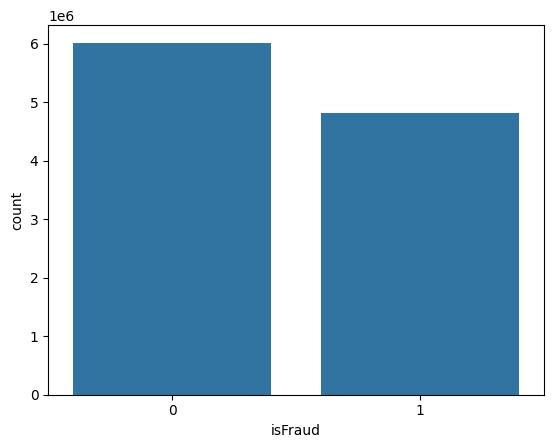

In [16]:
ax = sns.countplot(x="isFraud", data=df_banco)

<Axes: title={'center': 'Pearson Correlation of Features'}>

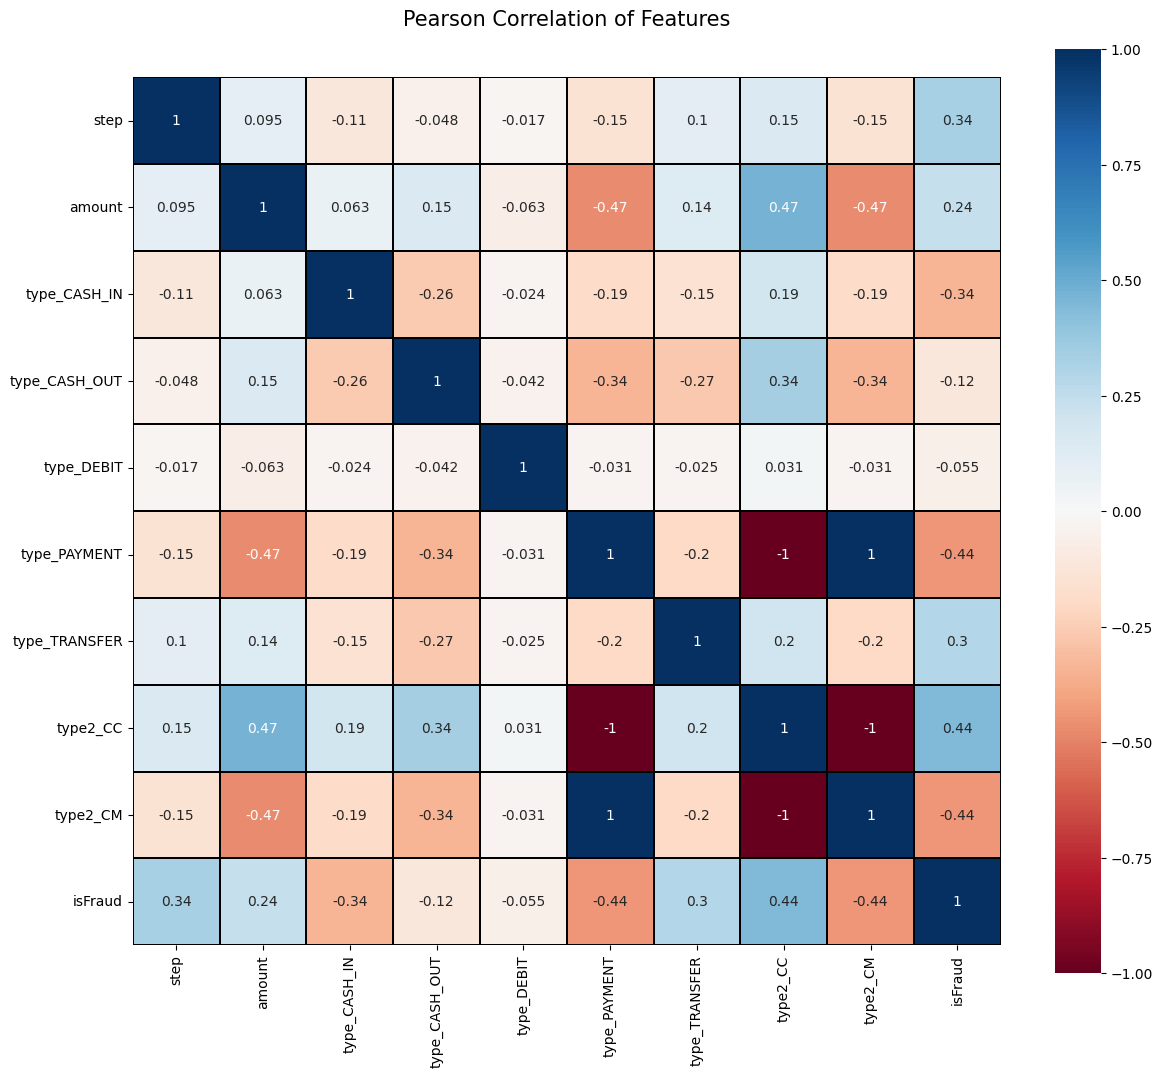

In [17]:
correlation_matrix = df_banco.corr()
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix,linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='black', annot=True)

Podemos observar que las columnas que más se correlacionan al label isFraud son:

De forma positiva: step, amount, type_TRANSFER, type2_CC

De forma negativa: type_DEBIT, type_PAYMENT, type_CASH_IN, type_CASH_OUT, type2_CC  (precisamente no hay fraudes para este tipo de transacciones)

###4. *CREACION DE LOS MODELOS*

In [18]:
def crea_modelos():
    global df_banco, resultados
    #Division de los datos
    y = df_banco['isFraud']
    x = df_banco.drop(columns='isFraud')
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.30, random_state = 77)
    #Inicializo modelo
    knn = KNeighborsClassifier(metric="euclidean")
    bnb = BernoulliNB()
    dtc = DecisionTreeClassifier(criterion="entropy", random_state = 42)
    rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
    #Entrenamiento del modelo
    knn.fit(train_x, train_y)
    bnb.fit(train_x, train_y)
    dtc.fit(train_x, train_y)
    rf.fit(train_x, train_y)
    #Resultados
    prediccion_knn = knn.predict(test_x)
    prediccion_bnb = bnb.predict(test_x)
    prediccion_dtc = dtc.predict(test_x)
    prediccion_rf = rf.predict(test_x)
    #Metricas de cada modelo
    accuracy_knn = accuracy_score(test_y, prediccion_knn)
    precision_knn = precision_score(test_y, prediccion_knn)
    recall_knn = recall_score(test_y, prediccion_knn)
    f1_score_knn = precision_score(test_y, prediccion_knn)
    auc_roc_knn = roc_auc_score(test_y, prediccion_knn)

    accuracy_bnb = accuracy_score(test_y, prediccion_bnb)
    precision_bnb = precision_score(test_y, prediccion_bnb)
    recall_bnb = recall_score(test_y, prediccion_bnb)
    f1_score_bnb = precision_score(test_y, prediccion_bnb)
    auc_roc_bnb = roc_auc_score(test_y, prediccion_bnb)

    accuracy_dtc = accuracy_score(test_y, prediccion_dtc)
    precision_dtc = precision_score(test_y, prediccion_dtc)
    recall_dtc = recall_score(test_y, prediccion_dtc)
    f1_score_dtc = precision_score(test_y, prediccion_dtc)
    auc_roc_dtc = roc_auc_score(test_y, prediccion_dtc)

    accuracy_rf = accuracy_score(test_y, prediccion_rf)
    precision_rf = precision_score(test_y, prediccion_rf)
    recall_rf = recall_score(test_y, prediccion_rf)
    f1_score_rf = precision_score(test_y, prediccion_rf)
    auc_roc_rf = roc_auc_score(test_y, prediccion_rf)

    #Lista de cada modelo y sus metricas
    nombre_modelo = []
    accuracy = []
    precision = []
    recall = []
    f1_score = []
    auc_roc = []
    nombre_modelo.append("Kneighbors")
    nombre_modelo.append("Bernoulli")
    nombre_modelo.append("DecisionTreeClassifier")
    nombre_modelo.append("RandomForest")
    accuracy.append(accuracy_knn)
    accuracy.append(accuracy_bnb)
    accuracy.append(accuracy_dtc)
    accuracy.append(accuracy_rf)
    precision.append(precision_knn)
    precision.append(precision_bnb)
    precision.append(precision_dtc)
    precision.append(precision_rf)
    recall.append(recall_knn)
    recall.append(recall_bnb)
    recall.append(recall_dtc)
    recall.append(recall_rf)
    f1_score.append(f1_score_knn)
    f1_score.append(f1_score_bnb)
    f1_score.append(f1_score_dtc)
    f1_score.append(f1_score_rf)
    auc_roc.append(auc_roc_knn)
    auc_roc.append(auc_roc_bnb)
    auc_roc.append(auc_roc_dtc)
    auc_roc.append(auc_roc_rf)
    #Resultados de las prediccion de cada modelo con sus respectivas metricas
    resultados = {
      'Nombre_Modelo': nombre_modelo,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1_Score': f1_score,
      'AUC_ROC': auc_roc
        }


In [19]:
crea_modelos()
for i, model in enumerate(resultados['Nombre_Modelo']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {resultados['Accuracy'][i]}")
    print(f"Precisión: {resultados['Precision'][i]}")
    print(f"Recall: {resultados['Recall'][i]}")
    print(f"F1-score: {resultados['F1_Score'][i]}")
    print(f"AUC-ROC: {resultados['AUC_ROC'][i]}\n")

Modelo: Kneighbors
Accuracy: 0.985129175241607
Precisión: 0.9679471483494257
Recall: 0.9996411253698729
F1-score: 0.9679471483494257
AUC-ROC: 0.9865809613692892

Modelo: Bernoulli
Accuracy: 0.7735636897922186
Precisión: 0.6624663982350152
Recall: 1.0
F1-score: 0.6624663982350152
AUC-ROC: 0.7962165442368387

Modelo: DecisionTreeClassifier
Accuracy: 0.9809858010071937
Precisión: 0.9697980506886243
Recall: 0.9879839351642405
F1-score: 0.9697980506886243
AUC-ROC: 0.9816858994776998

Modelo: RandomForest
Accuracy: 0.9744445224450988
Precisión: 0.9601449299872618
Recall: 0.9833137153154252
F1-score: 0.9601449299872618
AUC-ROC: 0.9753318030007148



###5.*VISUALIZACION DE LOS DATOS*

In [20]:
def visualiza_resultados():
    global df_banco, resultados
    results_df = pd.DataFrame(resultados)
    results_df.set_index('Nombre_Modelo', inplace=True)
    results_df = pd.DataFrame(resultados)
    results_df.set_index('Nombre_Modelo', inplace=True)
    results_df = results_df.T
    colors = ['#0077b6', '#CDDBF3','#9370DB', '#DDA0DD']
    results_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0, color=colors)
    plt.title('Comparación de Métricas por Modelo')
    plt.xlabel('Métricas')
    plt.ylabel('Puntuación')
    plt.legend(title='Modelos')
    plt.tight_layout()
    plt.show()

<ipython-input-20-4db3add6aee4>:9: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  results_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0, color=colors)
<ipython-input-20-4db3add6aee4>:9: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  results_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0, color=colors)


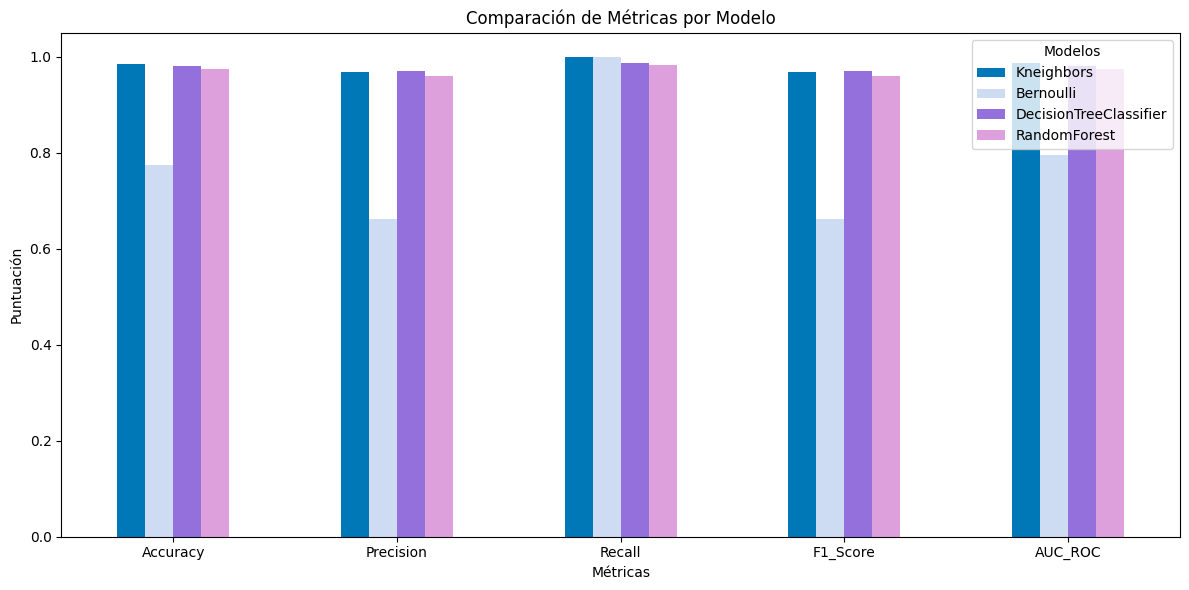

In [21]:
visualiza_resultados()

Finalmente viendo las metricas nos quedamos con el modelo K-Vecinos Cercanos ya que arrojo resultados mas cercanos al 100%.Es decir que del total de fraudes va a detectar un 99% de los casos por el recall y con una precision de 96%.